# Check lfp-derived spike waveforms

author: steeve.laquitaine@epfl.ch

In [ ]:
# SETUP PACKAGES 
%load_ext autoreload
%autoreload 2
import os 
import numpy as np
from matplotlib import pyplot as plt

# SET PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting"
os.chdir(PROJ_PATH)
from src.nodes.postpro import waveform
from src.nodes.utils import get_config
from src.nodes.truth.silico import ground_truth
from src.nodes.io.silico.loading import load_campaign_params


# SET PARAMETERS
EXPERIMENT = "supp/silico_reyes"    # specifies the experiment 
SIMULATION_DATE = "2023_01_13" # specifies the run (date)
MS_BEFORE = 3       # ms
MS_AFTER = 3        # ms
CELL_ID = 3754013   # the most active near-probe pyramidal cell
CHANNEL_IDS = np.arange(64,80).tolist()   # plot traces from channels nearest to filtered neuron group

# SETUP CONFIG
data_conf, param_conf = get_config(EXPERIMENT, SIMULATION_DATE).values()


# SETUP PATH
SPIKE_FILE_PATH = data_conf["sorting"]["simulation"]["ground_truth"]["input"]
RAW_LFP_TRACE_FILE_PATH = data_conf["dataeng"]["campaign"]["output"]["trace_file_path"]
CELL_TRACE_FILE_PATH = data_conf["dataeng"]["campaign"]["output"]["unit_trace_path"]+"cell_3754013_trace.pkl"


# SET WAVEFORM FOLDER
STUDY_FOLDER = data_conf["postprocessing"]["waveform"]["study"]


# FIGURE
FIG_PATH = data_conf["figures"]["silico"]["lfp_derived_waveforms"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2023-02-10 13:07:46,005 - root - utils.py - get_config - INFO - Reading experiment config.
2023-02-10 13:07:46,062 - root - utils.py - get_config - INFO - Reading experiment config. - done


## Check spikes signal-to-noise ratio and consistency 

1. We preprocess LFP traces
2. We extract the waveform
3. We plot the spike-triggered average

In [10]:
# Preprocess traces and extract waveforms (stats: 3 min for a 40 secs campaign, 1000 cells)
WaveformExtractor = waveform.run_from_files(
    experiment=EXPERIMENT,
    simulation_date=SIMULATION_DATE,
    lfp_trace_file=RAW_LFP_TRACE_FILE_PATH,
    spike_file=SPIKE_FILE_PATH,
    study_folder=STUDY_FOLDER,
    ms_before=MS_BEFORE,
    ms_after=MS_AFTER,
)

2023-02-10 13:07:57,074 - root - utils.py - get_config - INFO - Reading experiment config.
2023-02-10 13:07:57,093 - root - utils.py - get_config - INFO - Reading experiment config. - done
write_binary_recording with n_jobs = 1 and chunk_size = None
write_binary_recording with n_jobs = 1 and chunk_size = None


```diff
- Result: The spike waveforms of an example active pyramidal cell within 50 microns of a probe contact (green lines), overlaid on a spike triggered average plot, are clearly visible (above background noise) and consistent over time. But some 
```
Remarks TODO: 
* Some spikes do not look like spikes at all.
    * Hypothesis 1: these have the fewest samples (sometimes only one spike)
* Some spikes precede the timestamp. 
    * Hypothesis 1: what's visible is not our target cell's spikes but another cell's spikes, which would often precede our target cell's spikes)


In [11]:
# filter all near-contact pyramidal cells
simulation = load_campaign_params(data_conf)
Truth = ground_truth.run(simulation, data_conf, param_conf)[
    "ground_truth_sorting_object"
]
cell_morph = simulation["circuit"].cells.get(Truth.unit_ids, properties=["morph_class"])
CELL_IDS = cell_morph[cell_morph["morph_class"] == "PYR"].index.values
print("near-contact pyramidal cells (count): ", len(CELL_IDS))

near-contact pyramidal cells (count):  1090


In [26]:
# for each pyramidal cell (very slow takes 1h-ish)
for cell_i in CELL_IDS:

    # compute waveform plot
    fig = waveform.plot(WaveformExtractor=WaveformExtractor, cell_id=cell_i)

    # write
    if not os.path.isdir(f"{FIG_PATH}pyramidal/"):
        os.makedirs(f"{FIG_PATH}pyramidal/")
    fig.savefig(f"{FIG_PATH}pyramidal/cell_{cell_i}", dpi=300, bbox_inches="tight")

# show
# plt.show()

/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/src/nodes/postpro/waveform.py:121: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(3, 3))


## Check spikes visibility on nearby channels

TODO:
- Reiterate to improve

```diff
- Result: The spike waveforms are most visible on the channel (71) on which it has maximum positive and negative amplitudes and nearby channels (72,73,74) in agreement with its estimated location on channel 72, rightward to channel 71.
```

cell's waveforms (green) and its median (Fuchsia) by channel (pannels)


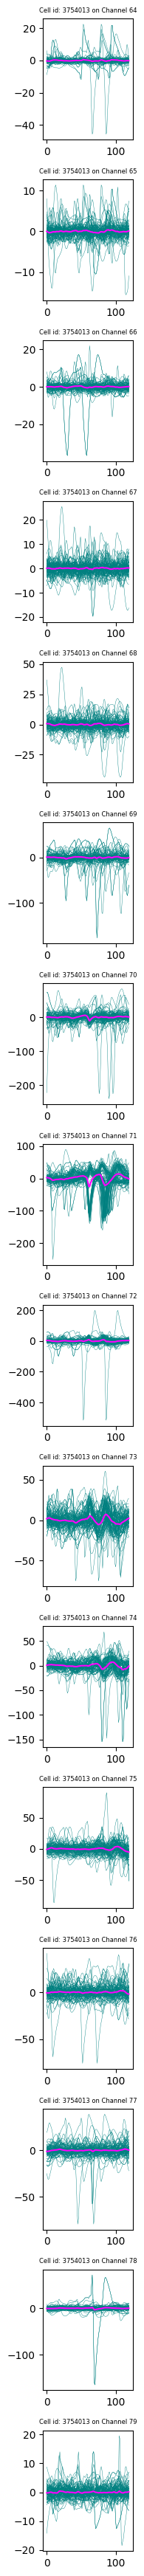

In [12]:
fig = waveform.plot_by_channel(
    WaveformExtractor, channel_ids=CHANNEL_IDS, cell_id=CELL_ID, figsize=(2, 35)
)
print("cell's waveforms (green) and its median (Fuchsia) by channel (pannels)")

3754013 : (106, 120, 128)
(120, 128)
channels (color)


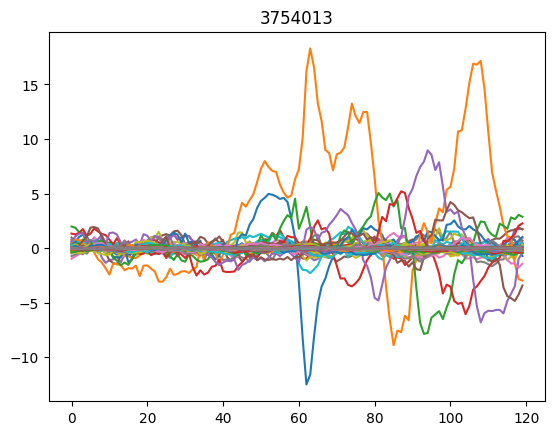

In [13]:
# get unit waveforms (n_spikes, n_sample, n_channels)
wfs = WaveformExtractor.get_waveforms(CELL_ID)
print(CELL_ID, ":", wfs.shape)

# plot unit median waveforms by channel
fig, ax = plt.subplots()
template = WaveformExtractor.get_template(unit_id=CELL_ID, mode="median")
print(template.shape)
ax.plot(template)
ax.set_title(f"{CELL_ID}")

print("channels (color)")